# **Prétraitement des Données et Modélisation avec LightGBM**


**Importer les bibliothèques nécessaires**

In [1]:
pip install numpy pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install termcolor


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install evidently


Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from lightgbm import LGBMClassifier, early_stopping
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
import gc
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
import shap
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import numpy as np
import gc
import time
from contextlib import contextmanager
from termcolor import cprint
import lightgbm as lgb
import xgboost as xgb
import plotly.express as px
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer, IterativeImputer
import lightgbm
print(lightgbm.__version__) 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score, classification_report
import os

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, GridSearchCV, FixedThresholdClassifier, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, make_scorer
import mlflow
from mlflow import log_metric, log_param, log_artifacts
import mlflow.sklearn
from sklearn.dummy import DummyClassifier
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

3.3.5


In [5]:
import sys
print(sys.executable)

c:\Users\Utilisateur\anaconda3\python.exe


In [6]:
# Afficher toutes les colonnes
pd.options.display.max_columns = None

# **Feature engineering**


Le processus d'ingénierie des caractéristiques que nous avons adopté est inspiré des travaux de l'utilisateur Aguiar, qui a appliqué plusieurs techniques pour extraire et transformer les données disponibles en fonctionnalités pertinentes pour le modèle de prédiction des risques de défaut de crédit.

In [7]:
# Mode débogage : calculs rapides sur un nombre limité de lignes (120 s pour l'ingénierie des fonctionnalités si debug=False)
debug = False
num_rows_debug = 2000

In [8]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# One-hot encoding for categorical columns with get_dummies


def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object'
    ]
    df = pd.get_dummies(df,
                        columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Preprocess application_train.csv and application_test.csv


def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv('C:\\Users\\Utilisateur\\Documents\\projet 7\\application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('C:\\Users\\Utilisateur\\Documents\\projet 7\\application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # les lignes de test_df sont concaténées après les lignes du dataset train
    df = pd.concat([df, test_df], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


# Preprocess bureau.csv and bureau_balance.csv


def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('C:\\Users\\Utilisateur\\Documents\\projet 7\\bureau.csv', nrows=num_rows)
    bb = pd.read_csv('C:\\Users\\Utilisateur\\Documents\\projet 7\\bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index(
        [e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        **num_aggregations,
        **cat_aggregations
    })
    bureau_agg.columns = pd.Index([
        'BURO_' + e[0] + "_" + e[1].upper()
        for e in bureau_agg.columns.tolist()
    ])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index([
        'ACTIVE_' + e[0] + "_" + e[1].upper()
        for e in active_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index([
        'CLOSED_' + e[0] + "_" + e[1].upper()
        for e in closed_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('C:\\Users\\Utilisateur\\Documents\\projet 7\\previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('C:\\Users\\Utilisateur\\Documents\\projet 7\\POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('C:\\Users\\Utilisateur\\Documents\\projet 7\\installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('C:\\Users\\Utilisateur\\Documents\\projet 7\\credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [9]:
# Retourne le nb de colonnes df
def nb_colonnes(df):
    cprint(f"Nb de colonnes du dataframe global: {len(df.columns)}",
           attrs=['bold'])


with timer("Full feature engineering run"):
    num_rows = num_rows_debug if debug else None
    df = application_train_test(num_rows)
    nb_colonnes(df)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    nb_colonnes(df)
  

    nb_colonnes(df)

Train samples: 307511, test samples: 48744
Nb de colonnes du dataframe global: 247
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 49s
Nb de colonnes du dataframe global: 363
Nb de colonnes du dataframe global: 363
Full feature engineering run - done in 58s


In [10]:
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_

In [11]:
df.shape

(356251, 363)

# **Transformation des données pour l'entraînement**

nous allons mettre  en place un processus complet de préparation des données et d'entraînement d'un modèle de classification en utilisant LightGBM, un puissant algorithme de Gradient Boosting. L'objectif est de prédire la probabilité de défaut de paiement sur un ensemble de données de crédit.

In [12]:
#Renommer les colonnes pour éviter l'erreur JSON avec LightGBM
df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))



# Séparer l'ensemble de données en train et test
df_train = df[df['TARGET'].notnull()]  # TARGET n'est pas null dans l'ensemble d'entraînement
df_test = df[df['TARGET'].isnull()]  # TARGET est null dans l'ensemble de test


# Séparer les caractéristiques (X) et les étiquettes (y)
x = df_train.drop(columns=['TARGET', 'SK_ID_CURR'])  # Supprimer TARGET et SK_ID_CURR
y = df_train['TARGET']  # Étiquette cible
X_test = df_test.drop(columns=['TARGET', 'SK_ID_CURR'])  # Supprimer TARGET et SK_ID_CURR


# Diviser les données d'entraînement en train et validation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)



In [13]:
# Afficher les formes des DataFrames
print("Forme de l'ensemble de données initial :", df.shape)
print("Forme de l'ensemble d'entraînement :", df_train.shape)
print("Forme de l'ensemble de test :", df_test.shape)

# Afficher les formes des caractéristiques (X) et étiquettes (y)
print("Forme de X (caractéristiques d'entraînement) :", x.shape)
print("Forme de y (étiquette cible d'entraînement) :", y.shape)
print("Forme de X_test (caractéristiques de test) :", X_test.shape)

# Afficher les formes des ensembles de train et test après la division
print("Forme de x_train (train) :", x_train.shape)
print("Forme de x_test (validation) :", x_test.shape)
print("Forme de y_train (étiquettes train) :", y_train.shape)
print("Forme de y_test (étiquettes validation) :", y_test.shape)

Forme de l'ensemble de données initial : (356251, 363)
Forme de l'ensemble d'entraînement : (307507, 363)
Forme de l'ensemble de test : (48744, 363)
Forme de X (caractéristiques d'entraînement) : (307507, 361)
Forme de y (étiquette cible d'entraînement) : (307507,)
Forme de X_test (caractéristiques de test) : (48744, 361)
Forme de x_train (train) : (276756, 361)
Forme de x_test (validation) : (30751, 361)
Forme de y_train (étiquettes train) : (276756,)
Forme de y_test (étiquettes validation) : (30751,)


In [14]:
x_train

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Const

In [15]:
columns_list = x_train.columns.tolist()
columns_list

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APA

In [16]:
# Afficher toutes les colonnes (features) du DataFrame
print(df.columns.tolist())


['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMEN

In [17]:
# Fonction pour calculer le Business Score
def business_score(y_true, y_pred):
    """
    Calcule le Business Score basé sur la matrice de confusion, 
    en attribuant des coûts spécifiques aux faux négatifs et faux positifs.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = 10 * fn + 1 * fp  # Coût total basé sur les faux négatifs et faux positifs
    max_cost = 10 * (fn + tp) + 1 * (fp + tn)  # Coût maximal possible
    return 1 - (total_cost / max_cost)  # Score plus élevé signifie moins de coûts

*Configuration de l'URI de tracking LightGBM*

In [18]:

import mlflow.lightgbm  # Extension MLflow pour LightGBM

# Configuration de l'URI de tracking
tracking_dir = r"C:\Users\Utilisateur\Downloads\mlruns"
os.makedirs(tracking_dir, exist_ok=True)  # Crée le répertoire s'il n'existe pas
mlflow.set_tracking_uri(f"file:///{tracking_dir}")

# Définir une expérimentation
mlflow.set_experiment("LightGBM Experimentation")
print(f"MLflow tracking configuré pour le chemin : {tracking_dir}")

MLflow tracking configuré pour le chemin : C:\Users\Utilisateur\Downloads\mlruns


*Configuration de l'URI de tracking DummyClassifier*

In [19]:


# Configuration de l'URI de tracking
tracking_dir = r"C:\Users\Utilisateur\Downloads\mlruns"
os.makedirs(tracking_dir, exist_ok=True)  # Crée le répertoire s'il n'existe pas
mlflow.set_tracking_uri(f"file:///{tracking_dir}")

# Définir une expérimentation
mlflow.set_experiment("Dummy Classifier Experimentation")
print(f"MLflow tracking configuré pour le chemin : {tracking_dir}")

MLflow tracking configuré pour le chemin : C:\Users\Utilisateur\Downloads\mlruns


In [20]:
# Définir une expérimentation
mlflow.set_experiment("Dummy Classifier Experimentation")
print(f"MLflow tracking configuré pour le chemin : {tracking_dir}") 

MLflow tracking configuré pour le chemin : C:\Users\Utilisateur\Downloads\mlruns


# **Tester DummyClassifier(strategy="most_frequent")**

In [21]:
# Initialiser le modèle DummyClassifier
clf = DummyClassifier(strategy="most_frequent")  # Utilisation de DummyClassifier avec 'most_frequent'

# Fixer le modèle avec le seuil ajustable 
fixed_clf = FixedThresholdClassifier(estimator=clf, threshold=0.5, response_method='predict_proba')

In [22]:
# Définir la grille de recherche des hyperparamètres
param_grid = {
    'estimator__strategy': ['most_frequent', 'stratified', 'uniform', 'constant'],  # Hyperparamètres pour DummyClassifier
    'estimator__constant': [0]  
} 

# Définir le scorer
scorer = make_scorer(business_score, greater_is_better=True, needs_proba=False)

In [23]:
# Définir le scorer
scorer = make_scorer(business_score, greater_is_better=True, needs_proba=False)

# Définir GridSearchCV
grid_search = GridSearchCV(
    fixed_clf, 
    param_grid, 
    scoring={"business": scorer, "AUC": "roc_auc", "Accuracy": "accuracy"}, 
    cv=2, 
    verbose=2, 
    refit="business"  # Indique quelle métrique utiliser pour réajuster le modèle final
)

# Lancer l'entraînement
grid_search.fit(x_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END estimator__constant=0, estimator__strategy=most_frequent; total time=   1.0s
[CV] END estimator__constant=0, estimator__strategy=most_frequent; total time=   0.8s
[CV] END estimator__constant=0, estimator__strategy=stratified; total time=   0.9s
[CV] END estimator__constant=0, estimator__strategy=stratified; total time=   0.7s
[CV] END .estimator__constant=0, estimator__strategy=uniform; total time=   0.8s
[CV] END .estimator__constant=0, estimator__strategy=uniform; total time=   1.0s
[CV] END estimator__constant=0, estimator__strategy=constant; total time=   0.9s
[CV] END estimator__constant=0, estimator__strategy=constant; total time=   0.6s


GridSearchCV(cv=2,
             estimator=FixedThresholdClassifier(estimator=DummyClassifier(strategy='most_frequent'),
                                                response_method='predict_proba',
                                                threshold=0.5),
             param_grid={'estimator__constant': [0],
                         'estimator__strategy': ['most_frequent', 'stratified',
                                                 'uniform', 'constant']},
             refit='business',
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy',
                      'business': make_scorer(business_score, response_method='predict')},
             verbose=2)

In [24]:
resultat = (
    pd.DataFrame(grid_search.cv_results_)
    .sort_values(by="mean_test_business", ascending=False)  
)

# Afficher les résultats
display(resultat)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__constant,param_estimator__strategy,params,split0_test_business,split1_test_business,mean_test_business,std_test_business,rank_test_business,split0_test_AUC,split1_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_Accuracy,split1_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy
0,0.651384,0.051290,0.378546,0.039782,0,most_frequent,"{'estimator__constant': 0, 'estimator__strateg...",0.532432,0.532432,0.532432,0.000000,1,0.500000,0.500000,0.500000,0.000000,2,0.919272,0.919272,0.919272,0.000000,1
3,0.595572,0.123018,0.265827,0.057263,0,constant,"{'estimator__constant': 0, 'estimator__strateg...",0.532432,0.532432,0.532432,0.000000,1,0.500000,0.500000,0.500000,0.000000,2,0.919272,0.919272,0.919272,0.000000,1
1,0.621196,0.055208,0.273677,0.036114,0,stratified,"{'estimator__constant': 0, 'estimator__strateg...",0.526848,0.524282,0.525565,0.001283,3,0.501246,0.502122,0.501684,0.000438,1,0.851031,0.851414,0.851223,0.000192,3
2,0.543507,0.095321,0.462573,0.047532,0,uniform,"{'estimator__constant': 0, 'estimator__strateg...",0.467568,0.467568,0.467568,0.000000,4,0.500000,0.500000,0.500000,0.000000,2,0.080728,0.080728,0.080728,0.000000,4


In [25]:
# Extraire les métriques et les hyperparamètres
mean_test_auc = np.mean(grid_search.cv_results_['mean_test_AUC'])
std_test_auc = np.std(grid_search.cv_results_['mean_test_AUC'])
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

# Enregistrer les résultats dans MLflow
with mlflow.start_run():
    mlflow.log_metric("Mean AUC", mean_test_auc)
    mlflow.log_metric("Std AUC", std_test_auc)
    mlflow.log_metric("Best Business Score", best_score)
    mlflow.log_params(best_params)
    mlflow.log_param("strategy", best_params['estimator__strategy'])
    if 'estimator__constant' in best_params:
        mlflow.log_param("constant_value", best_params['estimator__constant'])
    mlflow.log_param("threshold", best_params.get('threshold', 0.5))
    mlflow.sklearn.log_model(best_model, "model")

2024/11/30 11:09:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [26]:
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Current Experiment ID: {mlflow.get_experiment_by_name('Dummy Classifier Experimentation').experiment_id}")

MLflow Tracking URI: file:///C:\Users\Utilisateur\Downloads\mlruns
Current Experiment ID: 380342653041436062


# **Modele LightGBM**

In [27]:
# Initialiser le modèle LGBMClassifier
clf = lgb.LGBMClassifier(is_unbalance=True) # is_unbalance=True permet de gérer le déséquilibre des classes

# # Fixer le modèle avec le seuil ajustable
fixed_clf = FixedThresholdClassifier(estimator=clf, threshold=0.5, response_method='predict_proba')

In [28]:
# Définir la grille de recherche des hyperparamètres
param_grid = {
    'estimator__num_leaves': [3, 5, 9, 15],
    'estimator__num_iterations': [100, 150],
    'threshold': [0.1, 0.2],
    'estimator__learning_rate': [0.01, 0.05]  
}

In [29]:
# Définir le scorer
scorer = make_scorer(business_score, greater_is_better=True, needs_proba=False)

In [30]:
# Corrected GridSearchCV usage
grid_search = GridSearchCV(
    fixed_clf, 
    param_grid, 
    scoring={"business": scorer, "AUC": "roc_auc", "Accuracy": "accuracy"}, 
    cv=2, 
    verbose=2, 
    refit="business"  # Indique quelle métrique utiliser pour réajuster le modèle final
)

# Lancer l'entraînement
grid_search.fit(x_train, y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=3, threshold=0.1; total time=  26.2s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=3, threshold=0.1; total time=  17.2s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=3, threshold=0.2; total time=  15.9s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=3, threshold=0.2; total time=  16.7s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=5, threshold=0.1; total time=  17.4s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=5, threshold=0.1; total time=  16.9s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=5, threshold=0.2; total time=  17.0s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=5, threshold=0.2; total time=  17.2s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=9, threshold=0.1; total time=  17.3s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=9, threshold=0.1; total time=  17.9s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=9, threshold=0.2; total time=  17.8s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=9, threshold=0.2; total time=  17.2s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=15, threshold=0.1; total time=  19.1s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=15, threshold=0.1; total time=  18.5s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=15, threshold=0.2; total time=  18.8s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=100, estimator__num_leaves=15, threshold=0.2; total time=  18.6s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=3, threshold=0.1; total time=  16.8s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=3, threshold=0.1; total time=  16.0s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=3, threshold=0.2; total time=  15.5s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=3, threshold=0.2; total time=  16.0s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=5, threshold=0.1; total time=  17.7s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=5, threshold=0.1; total time=  17.0s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=5, threshold=0.2; total time=  16.8s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=5, threshold=0.2; total time=  17.0s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=9, threshold=0.1; total time=  20.1s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=9, threshold=0.1; total time=  21.3s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=9, threshold=0.2; total time=  18.7s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=9, threshold=0.2; total time=  22.8s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=15, threshold=0.1; total time=  24.4s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=15, threshold=0.1; total time=  26.0s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=15, threshold=0.2; total time=  29.6s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.01, estimator__num_iterations=150, estimator__num_leaves=15, threshold=0.2; total time=  25.0s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=3, threshold=0.1; total time=  17.2s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=3, threshold=0.1; total time=  16.1s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=3, threshold=0.2; total time=  16.7s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=3, threshold=0.2; total time=  19.7s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=5, threshold=0.1; total time=  17.0s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=5, threshold=0.1; total time=  20.7s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=5, threshold=0.2; total time=  19.9s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=5, threshold=0.2; total time=  23.4s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=9, threshold=0.1; total time=  23.2s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=9, threshold=0.1; total time=  22.0s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=9, threshold=0.2; total time=  19.5s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=9, threshold=0.2; total time=  22.5s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=15, threshold=0.1; total time=  23.1s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=15, threshold=0.1; total time=  27.0s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=15, threshold=0.2; total time=  22.9s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=100, estimator__num_leaves=15, threshold=0.2; total time=  22.1s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=3, threshold=0.1; total time=  21.6s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=3, threshold=0.1; total time=  20.3s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=3, threshold=0.2; total time=  17.8s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=3, threshold=0.2; total time=  17.7s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=5, threshold=0.1; total time=  22.1s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=5, threshold=0.1; total time=  25.6s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=5, threshold=0.2; total time=  35.5s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=5, threshold=0.2; total time=  50.0s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=9, threshold=0.1; total time=  54.4s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=9, threshold=0.1; total time= 1.5min


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=9, threshold=0.2; total time=  40.6s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=9, threshold=0.2; total time=  32.7s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=15, threshold=0.1; total time=  35.9s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=15, threshold=0.1; total time=  45.8s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=15, threshold=0.2; total time=  46.5s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END estimator__learning_rate=0.05, estimator__num_iterations=150, estimator__num_leaves=15, threshold=0.2; total time=  44.3s


c:\Users\Utilisateur\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


GridSearchCV(cv=2,
             estimator=FixedThresholdClassifier(estimator=LGBMClassifier(is_unbalance=True),
                                                response_method='predict_proba',
                                                threshold=0.5),
             param_grid={'estimator__learning_rate': [0.01, 0.05],
                         'estimator__num_iterations': [100, 150],
                         'estimator__num_leaves': [3, 5, 9, 15],
                         'threshold': [0.1, 0.2]},
             refit='business',
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy',
                      'business': make_scorer(business_score, response_method='predict')},
             verbose=2)

In [31]:
# Accéder aux résultats de la recherche par grille et les trier par 'mean_test_business' (ou autre métrique)
resultat = (
    pd.DataFrame(grid_search.cv_results_)
    .sort_values(by="mean_test_business", ascending=False)  
)

# Afficher les résultats
display(resultat)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__learning_rate,param_estimator__num_iterations,param_estimator__num_leaves,param_threshold,params,split0_test_business,split1_test_business,mean_test_business,std_test_business,rank_test_business,split0_test_AUC,split1_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_Accuracy,split1_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy
7,10.750380,0.062451,8.070950,0.038864,0.01,100,15,0.2,"{'estimator__learning_rate': 0.01, 'estimator_...",0.557076,0.554912,0.555994,0.001082,1,0.738324,0.734297,0.736310,0.002013,21,0.270715,0.267499,0.269107,0.001608,1
31,27.681766,0.214064,17.838079,1.306862,0.05,150,15,0.2,"{'estimator__learning_rate': 0.05, 'estimator_...",0.554477,0.551484,0.552981,0.001496,2,0.765164,0.763487,0.764325,0.000838,1,0.254130,0.247077,0.250603,0.003527,2
5,9.539832,0.242577,8.039716,0.054488,0.01,100,9,0.2,"{'estimator__learning_rate': 0.01, 'estimator_...",0.541715,0.542155,0.541935,0.000220,3,0.733004,0.729541,0.731273,0.001731,23,0.238210,0.240334,0.239272,0.001062,3
23,12.786676,0.341262,9.818293,0.099387,0.05,100,15,0.2,"{'estimator__learning_rate': 0.05, 'estimator_...",0.539882,0.539112,0.539497,0.000385,4,0.761599,0.759019,0.760309,0.001290,5,0.223142,0.221032,0.222087,0.001055,4
29,21.723370,0.293229,15.052546,3.658548,0.05,150,9,0.2,"{'estimator__learning_rate': 0.05, 'estimator_...",0.538509,0.537743,0.538126,0.000383,5,0.762370,0.760221,0.761296,0.001074,3,0.222138,0.217238,0.219688,0.002450,5
15,17.252286,0.718850,10.131253,1.611551,0.01,150,15,0.2,"{'estimator__learning_rate': 0.01, 'estimator_...",0.529979,0.529435,0.529707,0.000272,6,0.743357,0.739603,0.741480,0.001877,15,0.207215,0.205430,0.206323,0.000892,6
21,12.129539,0.962021,8.964628,0.543998,0.05,100,9,0.2,"{'estimator__learning_rate': 0.05, 'estimator_...",0.522215,0.521223,0.521719,0.000496,7,0.757527,0.755294,0.756411,0.001116,7,0.188476,0.185333,0.186905,0.001572,8
3,8.601934,0.054687,8.609635,0.124787,0.01,100,5,0.2,"{'estimator__learning_rate': 0.01, 'estimator_...",0.521441,0.518875,0.520158,0.001283,8,0.726098,0.721767,0.723932,0.002165,27,0.193058,0.186807,0.189933,0.003125,7
27,20.033277,1.849666,22.797560,5.381660,0.05,150,5,0.2,"{'estimator__learning_rate': 0.05, 'estimator_...",0.516857,0.515292,0.516075,0.000783,9,0.755879,0.754090,0.754985,0.000894,9,0.177405,0.173597,0.175501,0.001904,9
13,12.218051,1.389560,8.638527,0.668850,0.01,150,9,0.2,"{'estimator__learning_rate': 0.01, 'estimator_...",0.512889,0.511923,0.512406,0.000483,10,0.738556,0.735051,0.736803,0.001753,19,0.171530,0.168950,0.170240,0.001290,10


In [32]:
# Calcul des métriques moyennes et journaux dans MLflow
mean_test_auc = np.mean(grid_search.cv_results_['mean_test_AUC'])
std_test_auc = np.std(grid_search.cv_results_['mean_test_AUC'])
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

with mlflow.start_run():
    mlflow.log_metric("Mean AUC", mean_test_auc)
    mlflow.log_metric("Std AUC", std_test_auc)
    mlflow.log_metric("Optimized Threshold", best_params['threshold'])
    mlflow.log_metric("Best Business Score", best_score)
    mlflow.log_params(best_params)
    mlflow.log_param("num_leaves", best_params['estimator__num_leaves'])
    mlflow.log_param("num_iterations", best_params['estimator__num_iterations'])
    mlflow.log_param("threshold", best_params['threshold'])
    mlflow.log_param("learning_rate", best_params['estimator__learning_rate'])
    mlflow.sklearn.log_model(best_model, "model")


2024/11/30 11:35:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [33]:
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Current Experiment ID: {mlflow.get_experiment_by_name('LightGBM Experimentation').experiment_id}")


MLflow Tracking URI: file:///C:\Users\Utilisateur\Downloads\mlruns
Current Experiment ID: 649374020526112861


*Démarrer l’interface web MLflow*

Pour démarrer l’interface web de MLflow, on utilise cette commande dans le terminal. 

mlflow ui --backend-store-uri file:///C:/Users/Utilisateur/Downloads/mlruns

**Teste de  l'API**

In [34]:
#data = {
 #   '': [534],
  #  '': [531363010],
#}

# Convertir les données en DataFrame
#data_df = pd.DataFrame(data)

In [35]:

#logged_model = 'runs:/2517949830e6490d997d0dcfe3632167/model'

# Load model as a PyFuncModel.
#loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.

#loaded_model.predict(data_df)

*Model Registry et Serving avec MLflow*


In [36]:
#model_uri = f"runs:/{run.info.run_id}/model"
#mlflow.register_model(model_uri=model_uri, name="LightGBM_Model")

*Activation du Serving*

Pour servir le modèle, on utilise cette commande dans le terminal (après l'enregistrement).  

mlflow models serve -m runs:/<run_id>/model -p 1234

# **shap sur le meilleur modele**

                                 Feature  Importance
31                          EXT_SOURCE_2         284
32                          EXT_SOURCE_3         256
30                          EXT_SOURCE_1         217
244                         PAYMENT_RATE         144
10                         DAYS_EMPLOYED         124
0                            CODE_GENDER          60
125  NAME_EDUCATION_TYPE_Highereducation          59
9                             DAYS_BIRTH          40
13                           OWN_CAR_AGE          38
107         NAME_CONTRACT_TYPE_Cashloans          26


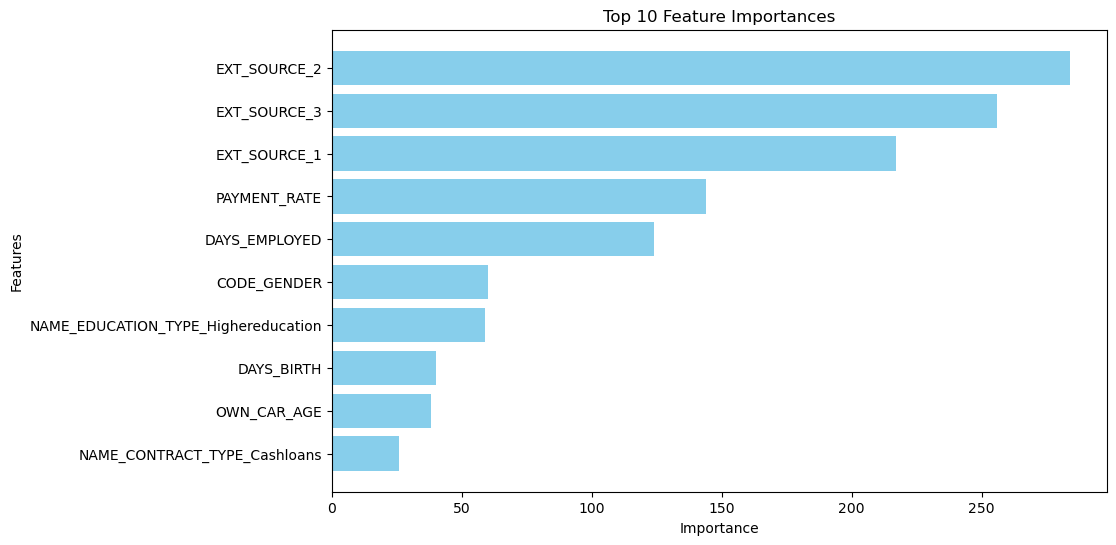

In [37]:
# Accéder à l'estimateur ajusté
fitted_model = grid_search.best_estimator_.estimator_  

# Vérifier si le modèle est bien ajusté
if not hasattr(fitted_model, "feature_importances_"):
    raise ValueError("Le modèle LightGBM n'est pas ajusté.")

# Importance des variables
feature_importances = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': fitted_model.feature_importances_
})

# Trier par importance décroissante
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Afficher les 10 principales variables
top_10_features = feature_importances.head(10)

# Afficher les résultats
print(top_10_features)

# Visualisation des 10 principales variables
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

**Importance globale SHAP**

c:\Users\Utilisateur\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


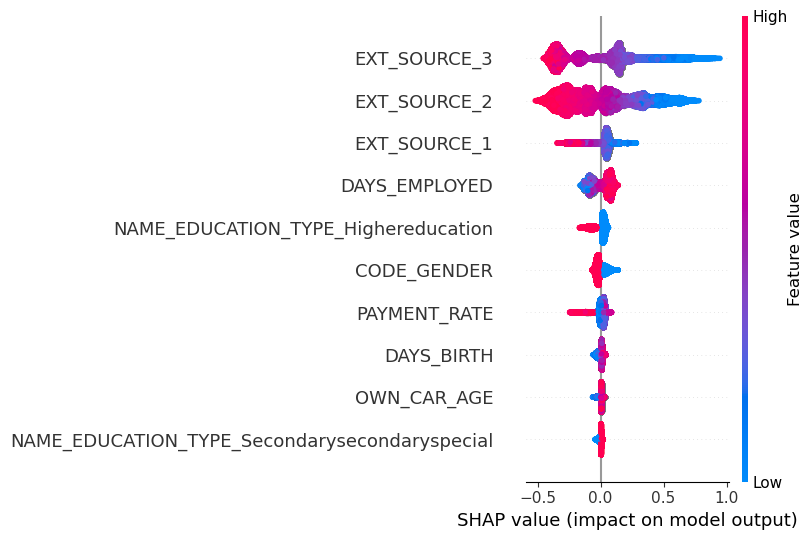

In [38]:
import shap
import matplotlib.pyplot as plt

# Assurez-vous que le modèle est bien ajusté avant d'utiliser SHAP
fitted_model = grid_search.best_estimator_.estimator_  # Accéder au modèle ajusté dans GridSearchCV

# Créer l'explainer SHAP pour le modèle LightGBM
explainer = shap.TreeExplainer(fitted_model)

# Calculer les valeurs SHAP pour l'ensemble d'entraînement
shap_values = explainer.shap_values(x_train)

# Visualiser l'importance globale des variables avec un graphique de résumé
shap.summary_plot(shap_values, x_train, max_display=10)  # Afficher les 10 variables les plus importantes




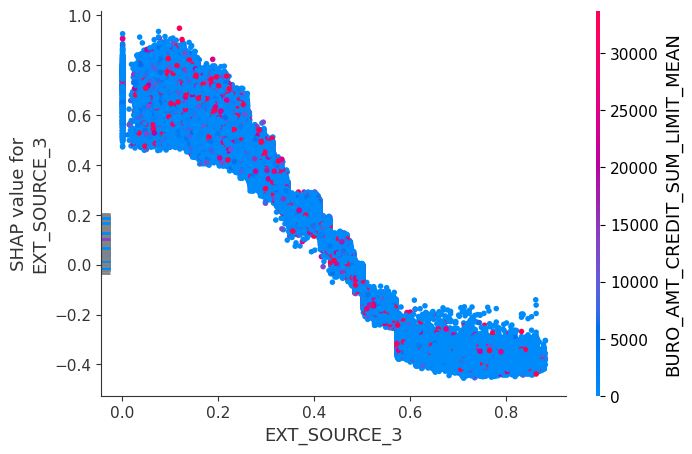

In [39]:
# Si vous souhaitez un graphique plus détaillé pour une variable en particulier :
shap.dependence_plot("EXT_SOURCE_3", shap_values, x_train)

In [40]:
df_shap = pd.DataFrame({
    'SHAP value': shap_values[1][0],
    'feature': x_train.columns
})
df_shap.sort_values(by='SHAP value', inplace=True)
df_shap

,SHAP value,feature
0,-0.012629,CODE_GENDER
244,-0.012629,PAYMENT_RATE
243,-0.012629,ANNUITY_INCOME_PERC
242,-0.012629,INCOME_PER_PERSON
241,-0.012629,INCOME_CREDIT_PERC
...,...,...
116,-0.012629,NAME_INCOME_TYPE_Businessman
115,-0.012629,NAME_TYPE_SUITE_Unaccompanied
114,-0.012629,NAME_TYPE_SUITE_Spousepartner
112,-0.012629,NAME_TYPE_SUITE_Other_A


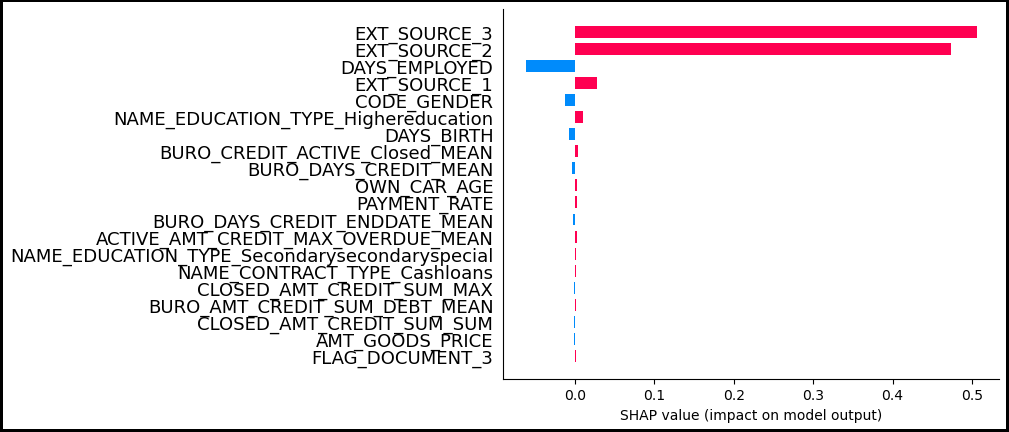

In [41]:
 #Calculer l'importance des variables avec SHAP pour la classe 1
plt.figure(edgecolor='black', linewidth=4)
shap.bar_plot(shap_values[1], 
              feature_names=x_train.columns,
              max_display=20)  
plt.show()

# **Tester le data drift entre l'ensemble train  avec la librairie evidently**

In [42]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Supprimer les colonnes cibles et les identifiants pour le test de drift
df_train_features = df_train.drop(columns=['TARGET', 'SK_ID_CURR'])
df_test_features = df_test.drop(columns=['TARGET', 'SK_ID_CURR'])

# Créer un rapport pour détecter le data drift
data_drift_report = Report(metrics=[
    DataDriftPreset()
])

# Ajouter les données train et test au rapport
data_drift_report.run(reference_data=df_train_features, current_data=df_test_features)

# Générer un fichier HTML pour visualiser le rapport
data_drift_report.save_html("data_drift_report.html")
print("Rapport de Data Drift généré : data_drift_report.html")

Rapport de Data Drift généré : data_drift_report.html


**Analyse approfondie des colonnes driftées**

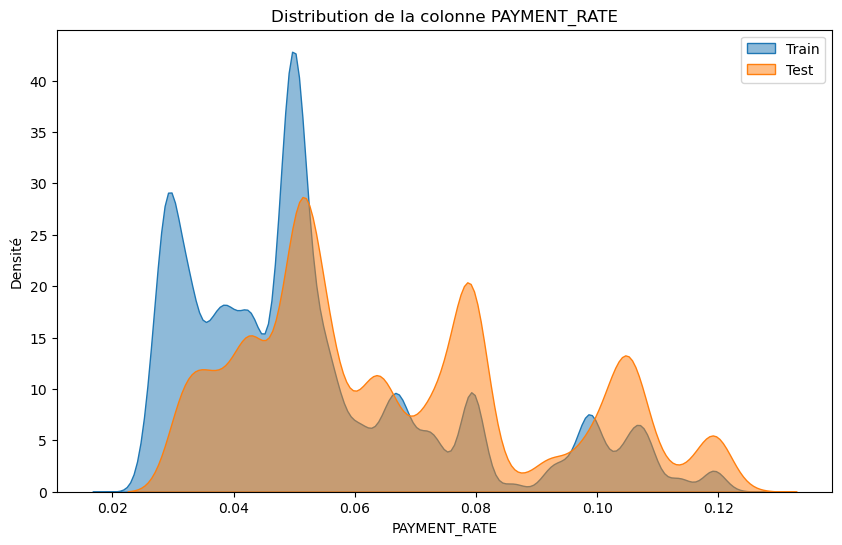

In [43]:

column = 'PAYMENT_RATE'

# Visualisation des distributions pour 'train' et 'test'
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train[column], label="Train", fill=True, alpha=0.5)
sns.kdeplot(df_test[column], label="Test", fill=True, alpha=0.5)
plt.title(f"Distribution de la colonne {column}")
plt.xlabel(column)
plt.ylabel("Densité")
plt.legend()
plt.show()


In [44]:
print("Statistiques descriptives - Train")
print(df_train[column].describe())

print("\nStatistiques descriptives - Test")
print(df_test[column].describe())


Statistiques descriptives - Train
count    307495.000000
mean          0.053695
std           0.022481
min           0.022073
25%           0.036900
50%           0.050000
75%           0.064043
max           0.124430
Name: PAYMENT_RATE, dtype: float64

Statistiques descriptives - Test
count    48720.000000
mean         0.066624
std          0.024559
min          0.031037
25%          0.048542
50%          0.061436
75%          0.079442
max          0.124430
Name: PAYMENT_RATE, dtype: float64


#  **Développement de l'api en flask**

**Enregistrer le modele sous un bon format**

In [45]:
import joblib

# Enregistrer le meilleur modèle trouvé lors de la recherche
joblib.dump(grid_search.best_estimator_, 'lgbm_model.pkl')


['lgbm_model.pkl']

In [46]:
# Charger le modèle enregistré
model = joblib.load('lgbm_model.pkl')

## **Dockerisation de l'application**

In [47]:
# Note:
#comment creer un environement virtuel? python -m venv env
#l'activer est .\env\Scripts\activate

**Construire l'image Docker avec cette commande:**

In [48]:
#docker build -t mon-projet7flask .

**Lancer le conteneur Docker:**

In [49]:
#docker run -p 8080:8080 mon-projet7flask

**Supprimez tous les conteneurs arrêtés :**

In [50]:
#docker container prune


# **Déploiement du modèle sur Google Cloud Platform (GCP)**


Pour deploié ce modele nous allons utiliser **google cloud plateform**, sur ceux nous allons creer un compte dans google cloud console.

1. une fois terminer nous instalame Google Cloud SDK et apres sur le terminal on tape la commande gcloud --version

2. apres installer google cloud nous allons realiser la deockerisation ( sur ceux on cree un fichier Dockerfile et .Dockerignore )

3. pour le deploiement on active Cloud Run API et Cloud Build API dans API et services > Bibliothèque

4. apres on Configure notre projet Google Cloud gcloud config set project YOUR_PROJECT_ID

gcloud config set project projet-7-modele-de-scoring

5. Pousser l'image Docker vers Google Container Registry (GCR)

* Taguer l'image Docker : docker tag mon-projet7flask gcr.io/YOUR_PROJECT_ID/mon-projet7flask
docker tag mon-projet7flask gcr.io/projet-7-modele-de-scoring/mon-projet7flask

* Pousser l'image Docker vers GCR: docker push gcr.io/YOUR_PROJECT_ID/mon-projet7flask
docker push gcr.io/projet-7-modele-de-scoring/mon-projet7flask

6. Déployer l'application sur Cloud Run : gcloud run deploy mon-projet7flask --image gcr.io/projet-7-modele-de-scoring/mon-projet7flask --platform managed --region europe-west9 --allow-unauthenticated

le lien: https://mon-projet7flask-225404997464.europe-west9.run.app

## **Creer une application streamlit**

1. installer streamlit 

# **Afficher les performance du modele**

In [51]:
# Obtenir le meilleur modèle après la recherche en grille
best_model = grid_search.best_estimator_

# Prédictions sur l'ensemble d'entraînement
y_train_pred = best_model.predict(x_train)  # Prédictions des classes (0 ou 1)

# Prédictions sur l'ensemble de test
y_test_pred = best_model.predict(x_test)

 

In [52]:
y_train_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [53]:
y_test_pred

array([1., 1., 1., ..., 1., 0., 1.])

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score

# Calculer la précision pour l'ensemble d'entraînement et de test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Afficher les matrices de confusion pour l'ensemble d'entraînement et de test
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculer l'AUC pour l'ensemble d'entraînement et l'ensemble de test
train_auc = roc_auc_score(y_train, best_model.predict_proba(x_train)[:, 1])  
test_auc = roc_auc_score(y_test, best_model.predict_proba(x_test)[:, 1])  

# Calculer le Recall pour l'ensemble d'entraînement et l'ensemble de test
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

# Affichage des résultats
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Train Confusion Matrix:\n{train_conf_matrix}")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Train AUC: {train_auc}")
print(f"Test AUC: {test_auc}")
print(f"Train Recall: {train_recall}")
print(f"Test Recall: {test_recall}")

Train Accuracy: 0.2643050195840379
Test Accuracy: 0.2684465545835908
Train Confusion Matrix:
[[ 51727 202687]
 [   921  21421]]
Test Confusion Matrix:
[[ 5886 22382]
 [  114  2369]]
Train AUC: 0.74289367419399
Test AUC: 0.7416638390809879
Train Recall: 0.9587771909408289
Test Recall: 0.9540877970197342


In [55]:
# Créer le DataFrame performance_totale avec toutes les métriques
performance_totale = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC', 'Recall'],
    'Train': [train_accuracy, train_auc, train_recall],
    'Test': [test_accuracy, test_auc, test_recall]
})

# Afficher le tableau final
print(performance_totale)

     Metric     Train      Test
0  Accuracy  0.264305  0.268447
1       AUC  0.742894  0.741664
2    Recall  0.958777  0.954088


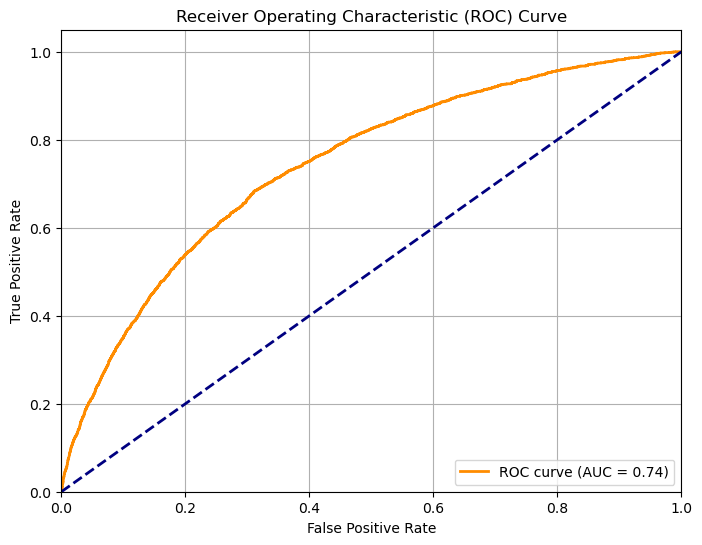

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculer les probabilités prédites pour l'ensemble de test (probabilités de classe positive)
y_test_prob = best_model.predict_proba(x_test)[:, 1]  # On prend la probabilité pour la classe 1

# Calculer les courbes ROC pour l'ensemble de test
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculer l'AUC
roc_auc = auc(fpr, tpr)

# Visualiser la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Ligne diagonale (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Accuracy: 0.2684
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.21      0.34     28268
         1.0       0.10      0.95      0.17      2483

    accuracy                           0.27     30751
   macro avg       0.54      0.58      0.26     30751
weighted avg       0.91      0.27      0.33     30751



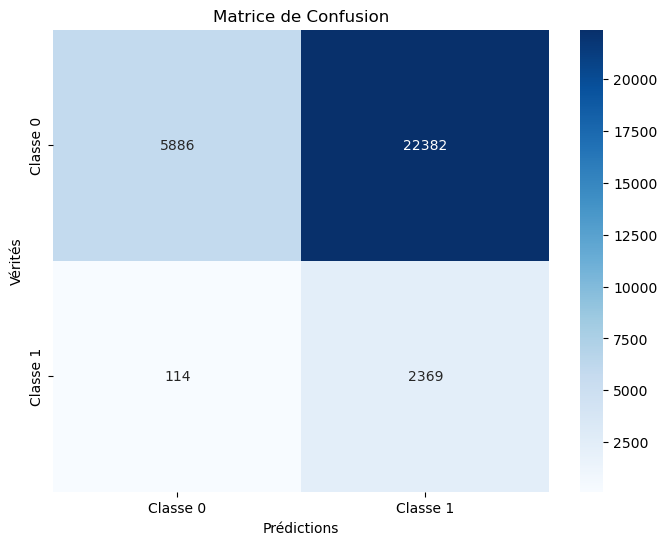

In [57]:
def metriques_classif_binaire(model, X_valid, y_valid):
    # Prédire les classes à l'aide du modèle
    y_pred = best_model.predict(X_valid)

    # Calcul des métriques
    accuracy = accuracy_score(y_valid, y_pred)
    cm = confusion_matrix(y_valid, y_pred)
    cr = classification_report(y_valid, y_pred)

    # Afficher les résultats
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{cr}")

    # Afficher la matrice de confusion sous forme d'image (heatmap)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités')
    plt.title('Matrice de Confusion')
    plt.show()

# Appeler la fonction 
metriques_classif_binaire(clf, x_test, y_test)  